# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

import cv2

## Setting up network and loading weights

In [2]:
model_name = "weights_19"

# download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("..","tmp","mono_model","models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("..","tmp","mono_model","models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

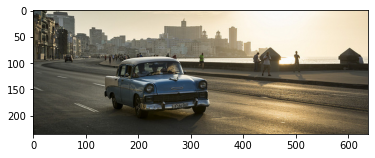

In [3]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path)
plt.imshow(input_image)

In [4]:
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [5]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
print(disp)

tensor([[[[0.0796, 0.0793, 0.0793,  ..., 0.0690, 0.0688, 0.0693],
          [0.0780, 0.0777, 0.0776,  ..., 0.0682, 0.0680, 0.0685],
          [0.0783, 0.0780, 0.0779,  ..., 0.0678, 0.0675, 0.0681],
          ...,
          [0.5013, 0.4934, 0.4930,  ..., 0.5177, 0.5172, 0.5188],
          [0.5053, 0.4978, 0.4981,  ..., 0.5246, 0.5246, 0.5263],
          [0.5093, 0.5030, 0.5032,  ..., 0.5301, 0.5302, 0.5318]]]])


## Plotting

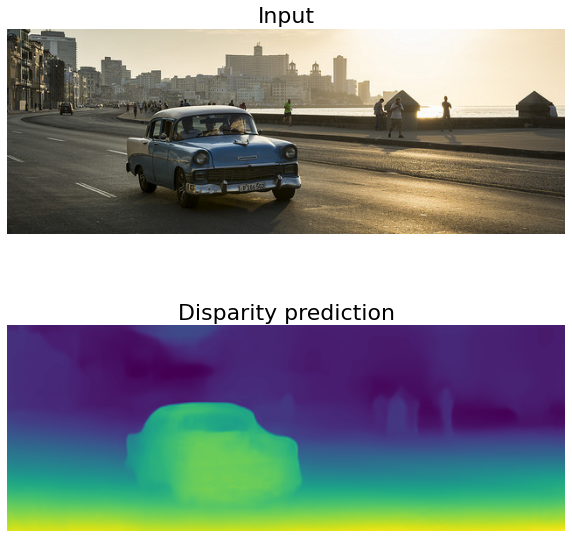

In [12]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

# plt.subplot(212)
# plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
# plt.title("Disparity prediction", fontsize=22)
# plt.axis('off');

plt.subplot(212)
plt.imshow(disp_resized_np)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

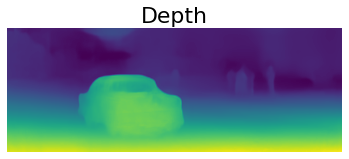

In [7]:
# plt.subplot(212)
plt.imshow(disp_resized_np)
plt.title("Depth", fontsize=22)
plt.axis('off');

In [8]:
def read_this(image_file, gray_scale=False):
    image_src = cv2.imread(image_file)
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src

In [9]:
def invert_this(image_src, with_plot=False, gray_scale=False):
    #image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    # image_i = ~ image_src
    image_i = 255 - image_src
    
    if with_plot:
        cmap_val = None if not gray_scale else 'gray'
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

        ax1.axis("off")
        ax1.title.set_text('Original')

        ax2.axis("off")
        ax2.title.set_text("Inverted")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_i, cmap=cmap_val)
        return True
    return image_i

True

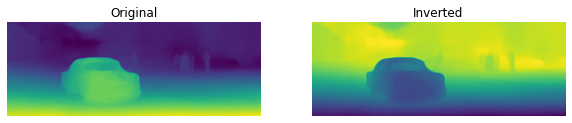

In [10]:
invert_this(image_src=disp_resized_np, with_plot=True)

In [11]:
# Need to get depth image from disparity through trilateration 

